# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.4 encode outliers and major land use types in the Teranet dataset

---

This notebook describes Step 2.4 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.
## Overview
### Mark outliers based on `price_to_med_xy` and `price_to_med_year`
Outliers are market by comparing price with medians for xy coordinate pair and for each year.
### New columns produced from `landuse`
One-hot encoded land use codes for major land uses are added to each Teranet records. In addition, all the values are combined into a single categorical column `landuse_class`. Only major land uses are encoded, the rest are represented by the value `Other`.

### Previous steps included: 

* **Step 2.1:** spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

    * for details, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`

* **Step 2.2:** correction for consistency of the Teranet records

    * column names were converted to lower case
    
    * inconsistent capitalizations were fixed for columns
    
        * `municipality`    
        * `street_name`
        * `street_designation`
        * `postal_code` (did not show problems, converted as a preventive measure)
        
    * columns `province` and `street_suffix` were removed from the dataset
    
    * new column `street_name_raw` was created: reserve copy of unmodified `street_name`
    
    * column `street_name` was parsed and cleaned for:
    
        * `postal_code`
        * `unitno`
        * `street_number`
        * `street_direction`
        * `street_designation`
        
    * plots of the count and percentage of missing values per column were produced
    
    * inconsistent entries were fixed in the following columns:
        
        * `street_direction`
        * `street_designation`
        * `municipality`
        * `street_name`
        * `unitno`
        
    * for details, see `notebooks/2.scrub/2.2_teranet_consistency.ipynb`

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for the Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.

For description of Step 2.2 of the cleanup process, see `notebooks/2.scrub/2.2_teranet_consistency.ipynb`.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from time import time

sns.set()

In [2]:
import sys

sys.path.append('../../src')

from plot_utils import plot_hist
from model_utils import fit_model

## Load Teranet data

In [3]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '4_Teranet_lu_encode.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [4]:
t = time()

df = pd.read_csv(data_path + '3_Teranet_nonan_new_cols.csv',
                 parse_dates=['registration_date'], low_memory=False)
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 65.75 seconds (1.10 minutes)
with 5,188,513 rows
and 55 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'pric

In [5]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5188513 entries, 0 to 5188512
Data columns (total 55 columns):
transaction_id               5188513 non-null int64
lro_num                      5188513 non-null int64
pin                          5188513 non-null int64
consideration_amt            5188513 non-null float64
registration_date            5188513 non-null datetime64[ns]
postal_code                  4881914 non-null object
unitno                       1332616 non-null object
street_name                  5144061 non-null object
street_designation           5090453 non-null object
street_direction             550657 non-null object
municipality                 5187161 non-null object
street_number                5142790 non-null object
x                            5188513 non-null float64
y                            5188513 non-null float64
dauid                        5188513 non-null int64
csduid                       5188513 non-null int64
csdname                      51885

## Mark top outliers based on `price_to_med_xy` and `price_to_med_year`
Outliers with high transaction volumes are marked with a boolean variable `outlier` in the following cases:
* if their value of `price_to_med_year` is greater than 5
* if their value of `price_to_med_xy` is greater that 2.5 (5 standard deviations above the mean)

### Based on `price_to_med_year`

In [6]:
# set criteria for outliers
max_price = 3
mask1 = df['price_to_med_year'] > max_price
suf = 'y_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_y_3` was added to the DataFrame.
Mean price of all records that are marked as outliers: 9,201,028.01
Mean price of all records that are not marked as outliers: 355,344.18


False    4936976
True      251537
Name: outlier_y_3, dtype: int64

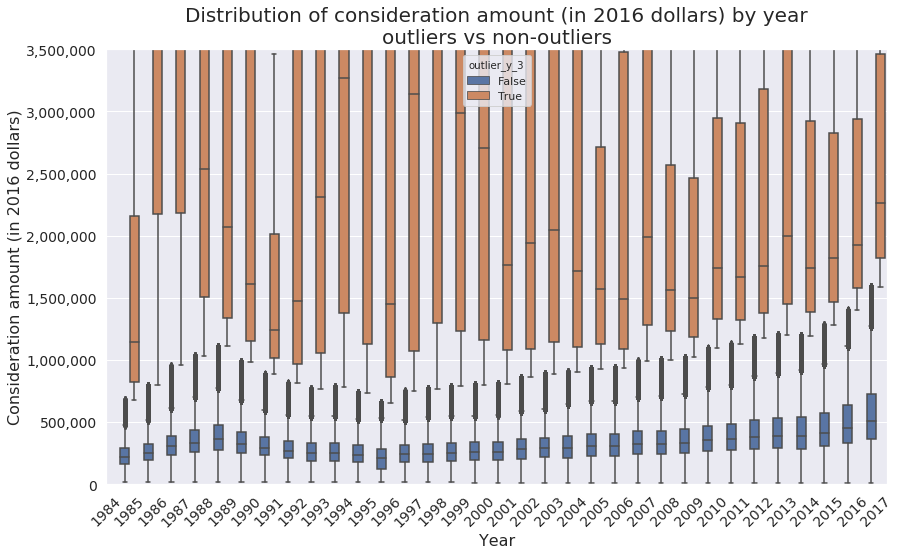

In [7]:
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [8]:
# set criteria for outliers
max_price = 5
mask1 = df['price_to_med_year'] > max_price
suf = 'y_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_y_5` was added to the DataFrame.
Mean price of all records that are marked as outliers: 15,712,333.55
Mean price of all records that are not marked as outliers: 376,902.10


False    5050699
True      137814
Name: outlier_y_5, dtype: int64

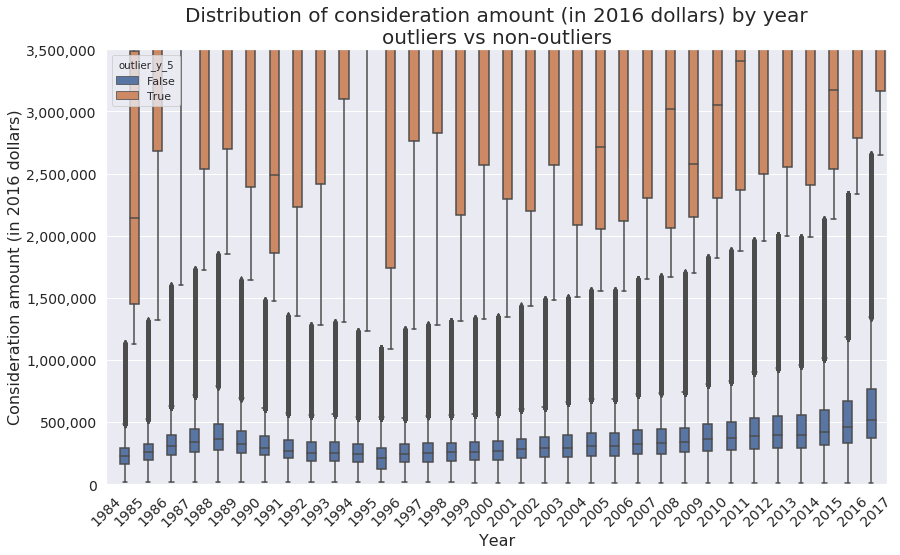

In [9]:
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [10]:
# set criteria for outliers
max_price = 10
mask1 = df['price_to_med_year'] > max_price
suf = 'y_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_y_10` was added to the DataFrame.
Mean price of all records that are marked as outliers: 24,227,469.69
Mean price of all records that are not marked as outliers: 397,286.53


False    5104253
True       84260
Name: outlier_y_10, dtype: int64

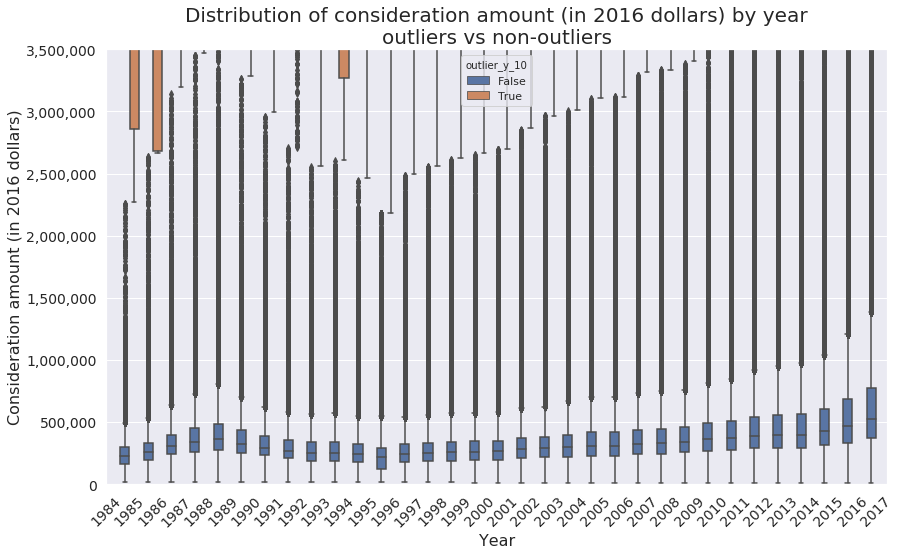

In [11]:
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [12]:
# set criteria for outliers
max_price = 20
mask1 = df['price_to_med_year'] > max_price
suf = 'y_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_y_20` was added to the DataFrame.
Mean price of all records that are marked as outliers: 35,400,277.03
Mean price of all records that are not marked as outliers: 421,195.46


False    5134647
True       53866
Name: outlier_y_20, dtype: int64

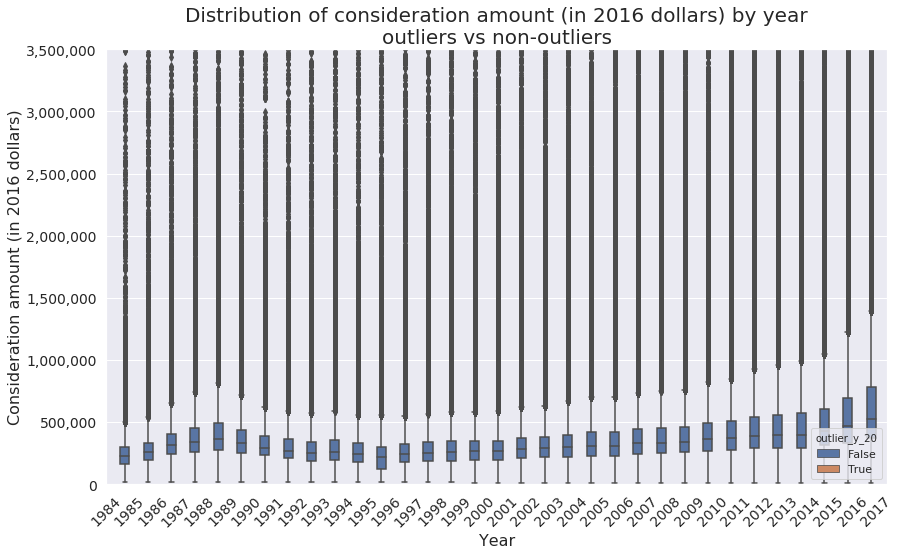

In [13]:
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

### Based on `price_to_med_xy`

In [14]:
# set criteria for outliers
max_price = 2
mask1 = df['price_to_med_xy'] > max_price
suf = 'xy_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_xy_2` was added to the DataFrame.
Mean price of all records that are marked as outliers: 8,386,852.25
Mean price of all records that are not marked as outliers: 541,711.36


False    5027851
True      160662
Name: outlier_xy_2, dtype: int64

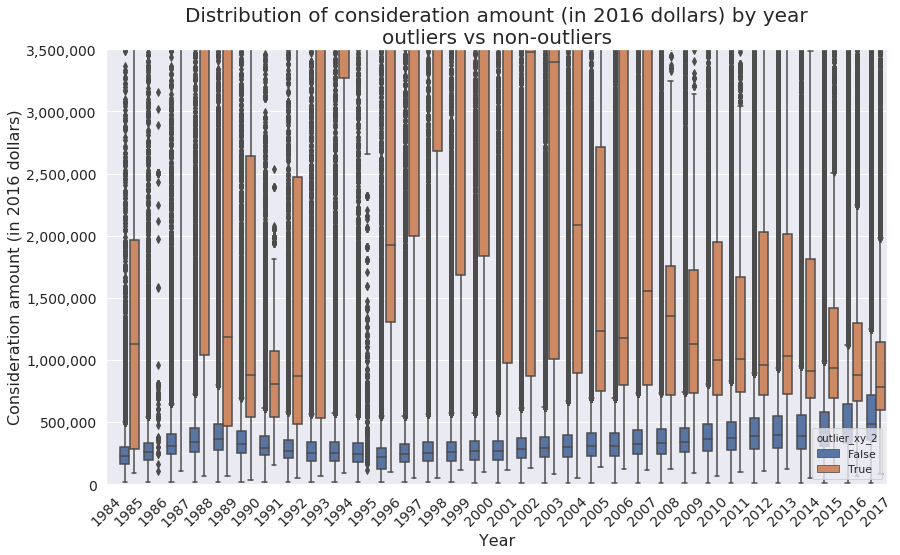

In [15]:
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [16]:
# set criteria for outliers
max_price = 4
mask1 = df['price_to_med_xy'] > max_price
suf = 'xy_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_xy_4` was added to the DataFrame.
Mean price of all records that are marked as outliers: 20,927,334.31
Mean price of all records that are not marked as outliers: 557,893.36


False    5130747
True       57766
Name: outlier_xy_4, dtype: int64

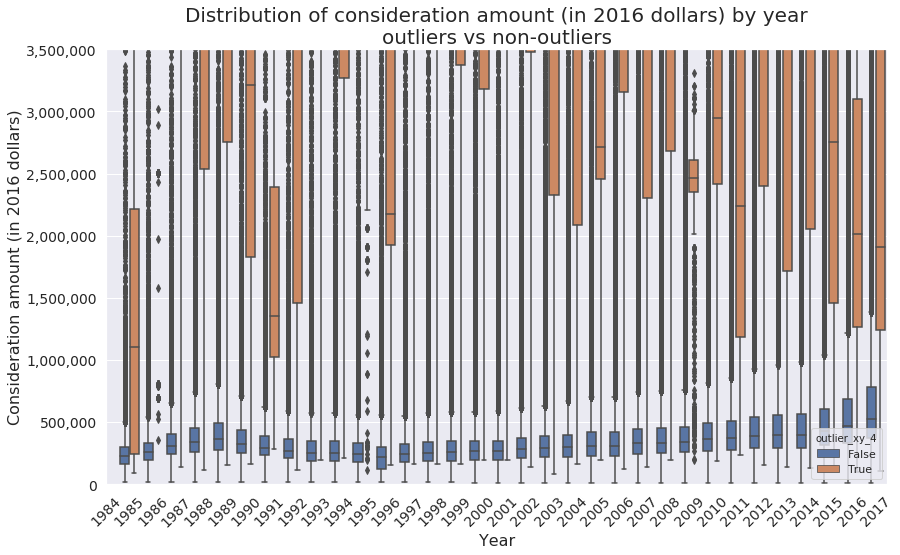

In [17]:
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [18]:
# set criteria for outliers
max_price = 10
mask1 = df['price_to_med_xy'] > max_price
suf = 'xy_'

# mark outliers
df.loc[mask1, 'outlier_' + suf + str(max_price)] = True
df['outlier_' + suf + str(max_price)] = df['outlier_' + suf + str(max_price)].fillna(False)
print("New column `outlier_{0}{1}` was added to the DataFrame.".format(suf, max_price))

print('Mean price of all records that are marked as outliers: {0:,.2f}'
      .format(df.query('{0} == True'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
print('Mean price of all records that are not marked as outliers: {0:,.2f}'
      .format(df.query('{0} == False'.format('outlier_' + suf + str(max_price)))['price_2016'].mean()))
df['outlier_' + suf + str(max_price)].value_counts()

New column `outlier_xy_10` was added to the DataFrame.
Mean price of all records that are marked as outliers: 31,470,942.38
Mean price of all records that are not marked as outliers: 571,639.20


False    5152735
True       35778
Name: outlier_xy_10, dtype: int64

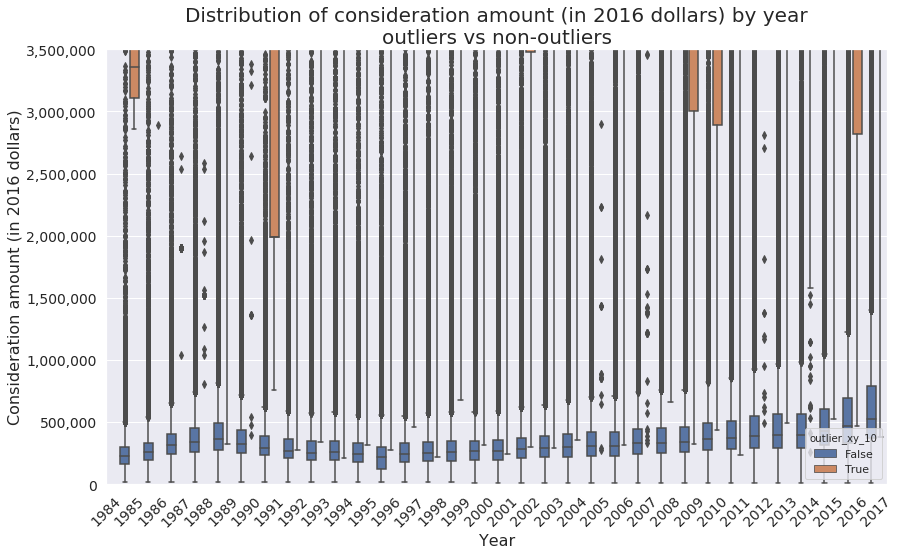

In [19]:
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df, x='year', y='price_2016', hue='outlier_' + suf + str(max_price), ax=ax)
ax.set_xlim(107, 140.5)
ax.set_ylim(0, 3500000)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.set_ylabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title("Distribution of consideration amount (in 2016 dollars) by year"
             "\noutliers vs non-outliers", fontsize=20)
ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

## Add column `lu_code`: join land use codes for GTA
Hamilton land use codes have been converted to match GTA codes in step 2.1.4.

### Read land use codes for GTA used by geography department

In [20]:
landuse_code_path = data_path + 'ParcelLandUse/GTA/'
os.listdir(landuse_code_path)

['GTA_land_use_code.txt',
 'GTAparcel16LU12.shx',
 'with_epoi',
 'GTAparcel16LU12.prj',
 'gta_land_use_code.csv',
 'GTAparcel16LU12.cpg',
 'GTAparcel16LU12.shp',
 'GTAparcel16LU12.dbf']

In [21]:
land_use_codes = pd.read_csv(landuse_code_path + 'gta_land_use_code.csv')
land_use_codes.head()

,landuse,code
0,0,Uncoded
1,1,Single Detached House
2,2,Commercial/Shopping
3,3,Industrial/Employment Lands
4,4,Government/Institutional


### Join land use codes to Teranet records

In [22]:
# join GTA land use codes
df = pd.merge(df, land_use_codes, how='left',
              left_on='landuse', right_on='landuse')
print("GTA land use codes were joined to the DataFrame.")
df['code'].value_counts().head(10)

GTA land use codes were joined to the DataFrame.


Single Detached House                          2189784
Apartments/Condos/Residence                    1102936
Strata Townhouses                               313918
Duplex/Semi-Detached                            244329
Townhouse                                       178585
Mix(Commercial Residential)                     167410
Underdeveloped Land                             153307
Mixed Complex (Residential, Office, Retail)     112398
Industrial/Employment Lands                     106056
Commercial/Shopping                             102172
Name: code, dtype: int64

## One-hot encode top 10 land uses by frequency
Top 10 land uses by count of Teranet records are one-hot (binary) encoded into separate variables.

In [23]:
outlier_col = 'outlier_y_10'

### Single Detached House
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

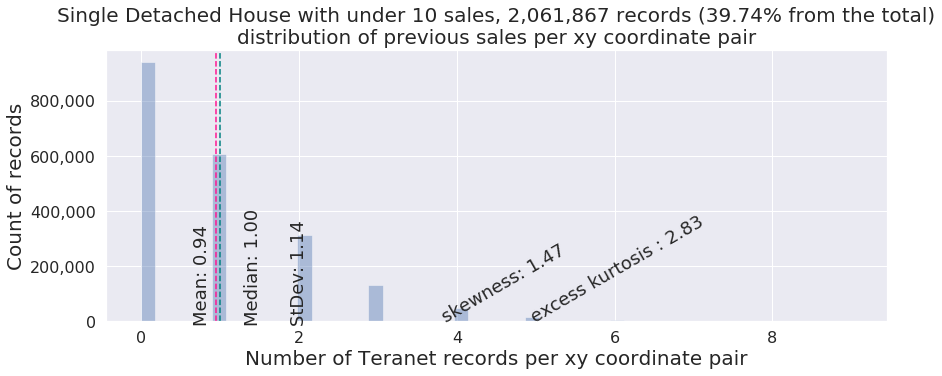

In [61]:
lu_type = 'Single Detached House'
max_sales = 10
mask1 = df['code'] == lu_type
mask2 = df['xy_prev_sales'] < max_sales
mask3 = df[outlier_col] == False
s = df[mask1 & mask2 & mask3]

plot_hist(s['xy_prev_sales'], form_y=True, 
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of previous sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=0.7, med_xlift=1.3, sdev_xlift=2)

In [65]:
def plot_hist(ser, form_x=False, form_y=False, width=14, height=5, min_x=None, max_x=None,
              kde=False, rug=False, x_label=None, bins=None,
              skew_kurt=True, plot_mean=True, plot_median=True, sdev=True,
              mean_xlift=1.1, med_xlift=0.7, sdev_xlift=1.3, skew_xlift=2, kurt_xlift=1.3, skew_kurt_rot=30,
              title='Distribution', title_size=20,
              x_tick_size=16, y_tick_size=16, x_lab_size=20, y_lab_size=20, mean_med_size=18,
              act='show', save_path='distribution.png', dpi=300, save_only=True):
    """
    plot distribution of the provided series
    :param ser: numpy array or pandas Series
    series from which to plot distributions
    :param form_x: boolean
    whether to add thousands separator to the x tick labels
    :param form_y: boolean
    whether to add thousands separator to the y tick labels
    :param figsize: tuple (float, float)
    size of the figure (width, height)
    :param kde: boolean
    whether to plot kernel density estimation (default = histogram)
    :param x_label: string
    label to use for x axis
    :param plot_mean: boolean
    whether to plot the mean of the series
    :param plot_median: boolean
    whether to plot the median of the series
    :param mean_xlift: float
    caption lift along the x axis for the mean
    :param med_xlift: float
    caption lift along the x axis for the median
    :param sdev: boolean
    whether to plot the standard deviation of the series
    :param sdev_xlift: float
    caption lift along the x axis for standard deviation
    :param title: string
    plot title
    :param title_size: float
    fontsize to use for the plot title
    :param x_tick_size: float
    fontsize to use for x ticks
    :param y_tick_size: float
    fontsize to use for y ticks
    :param x_lab_size: float
    fontsize to use for x axis label
    :param y_lab_size: float
    fontsize to use for y axis label
    :param mean_med_size: float
    fontsize to use for mean, median and standard deviation
    :param act: string ('show' or 'save')
    whether to show or save the plot
    :param save_path: string
    where to save the plot (relative from script location)
    :param dpi: int
    resolution for saving the plot
    :param save_only: boolean
    save without displaying
    :return: None, plots and displays or saves the result
    """
    # create figure and axis
    f, ax = plt.subplots(1, figsize=(width, height))

    # plot distribution
    sns.distplot(ser, kde=kde, rug=rug, bins=bins, ax=ax)

    # plot mean of the series
    if plot_mean:
        mean = ser.mean()
        ax.axvline(mean, linestyle='--', color='deeppink')
        ax.text(mean * mean_xlift, 0, 'Mean: {0:,.2f}'.format(mean), fontsize=mean_med_size, rotation=90)
    # plot median of the series
    if plot_median:
        median = ser.median()
        ax.axvline(median, linestyle='--', color='teal')
        ax.text(median * med_xlift, 0, 'Median: {0:,.2f}'.format(median), fontsize=mean_med_size, rotation=90)
    # print standard deviation of the series
    if sdev:
        ax.text(mean * sdev_xlift, 0, 'StDev: {0:,.2f}'.format(ser.std()), fontsize=mean_med_size, rotation=90)
    # print excess kurtosis and skewness
    if skew_kurt:
        ax.text(mean * skew_xlift * sdev_xlift, 0, 'skewness: {0:.2f}'.format(skew(ser)),
                fontsize=mean_med_size, rotation=skew_kurt_rot)
        ax.text(mean * skew_xlift * kurt_xlift * sdev_xlift, 0, 'excess kurtosis : {0:.2f}'.format(kurtosis(ser)),
                fontsize=mean_med_size, rotation=skew_kurt_rot)

    # format axes
    if form_x:
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if form_y:
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # configure axes parameters
    ax.set_title(title, fontsize=title_size)
    plt.xticks(fontsize=x_tick_size)
    plt.yticks(fontsize=y_tick_size)
    if kde:
        ax.set_ylabel('Kernel density estimation (KDE)', fontsize=y_lab_size)
    else:
        ax.set_ylabel('Count of records', fontsize=y_lab_size)

    if x_label:
        ax.set_xlabel(x_label, fontsize=x_lab_size)

    if min_x or max_x:
        ax.set_xlim(left=min_x, right=max_x)

    # save or show results
    if act == 'show':
        plt.show()
    elif act == 'save':
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print("Saved output plot to", save_path)
        if save_only:
            plt.close(f)

In [66]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=1.05, med_xlift=0.7, sdev_xlift=1.5, max_x=2000000, bins=100, rug=True)

KeyboardInterrupt: 

#### Add new binary variable and new class to `lu_class`

In [26]:
df.loc[mask1 & mask2 & mask3, 'lu_class'] = lu_type
df.loc[mask1 & mask2 & mask3, 'luc_detached'] = True
df['luc_detached'] = df['luc_detached'].fillna(False)
df['luc_detached'].value_counts()

False    3126646
True     2061867
Name: luc_detached, dtype: int64

### Apartments/condos/residence
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

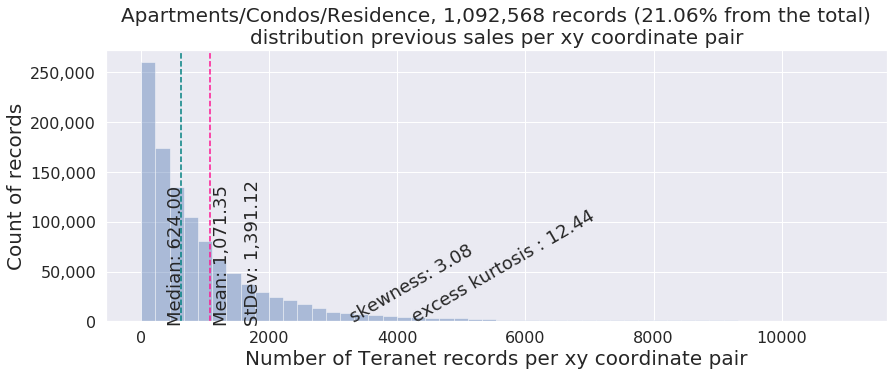

In [27]:
lu_type = 'Apartments/Condos/Residence'
mask1 = df['code'] == lu_type
mask2 = df[outlier_col] == False
s = df[mask1 & mask2]

plot_hist(s['xy_prev_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
                "\ndistribution previous sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", mean_xlift=1.05, med_xlift=0.65, sdev_xlift=1.5)

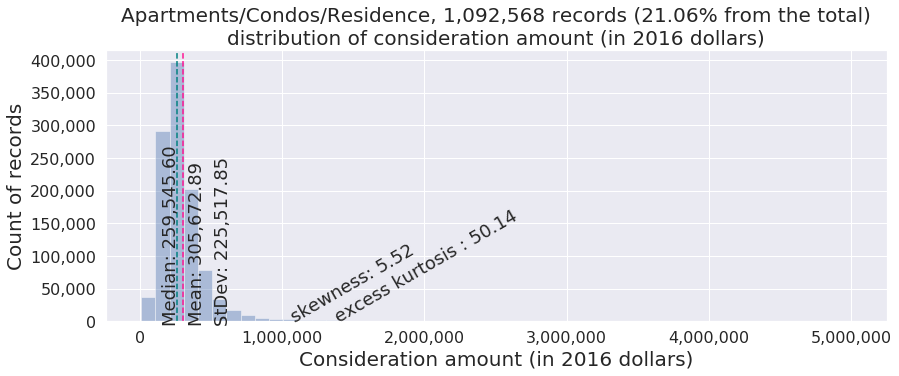

In [28]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
                "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", mean_xlift=1.1, med_xlift=0.6, sdev_xlift=1.7)

#### Add new binary variable and new class to `lu_class`

In [29]:
df.loc[mask1 & mask2, 'lu_class'] = lu_type
df.loc[mask1 & mask2, 'luc_condo'] = True
df['luc_condo'] = df['luc_condo'].fillna(False)
df['luc_condo'].value_counts()

False    4095945
True     1092568
Name: luc_condo, dtype: int64

### Strata Townhouses
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

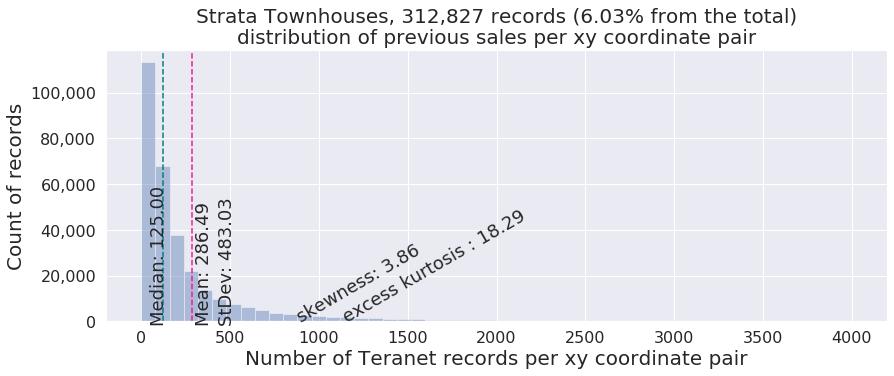

In [30]:
lu_type = 'Strata Townhouses'
mask1 = df['code'] == lu_type
mask2 = df[outlier_col] == False
s = df[mask1 & mask2]

plot_hist(s['xy_prev_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
                "\ndistribution of previous sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", mean_xlift=1.05, med_xlift=0.4, sdev_xlift=1.5)

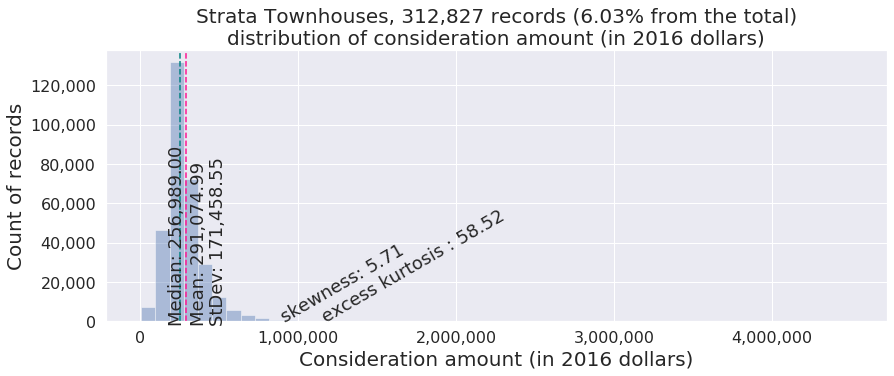

In [31]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)".format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", mean_xlift=1.1, med_xlift=0.7, sdev_xlift=1.5)

#### Add new binary variable and new class to `lu_class`

In [32]:
df.loc[mask1 & mask2, 'lu_class'] = lu_type
df.loc[mask1 & mask2, 'luc_strata'] = True
df['luc_strata'] = df['luc_strata'].fillna(False)
df['luc_strata'].value_counts()

False    4875686
True      312827
Name: luc_strata, dtype: int64

### Duplex/Semi-Detached
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

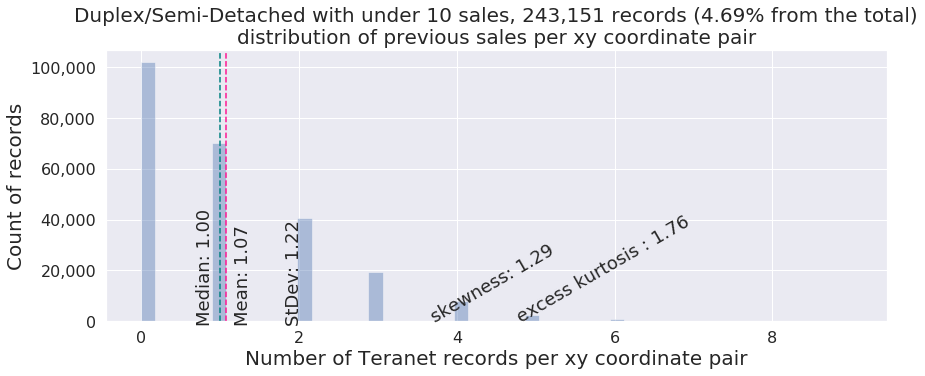

In [33]:
lu_type = 'Duplex/Semi-Detached'
max_sales = 10
mask1 = df['code'] == lu_type
mask2 = df['xy_prev_sales'] < max_sales
mask3 = df[outlier_col] == False
s = df[mask1 & mask2 & mask3]

plot_hist(s['xy_prev_sales'], form_y=True, 
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of previous sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.1, med_xlift=0.7, sdev_xlift=1.7)

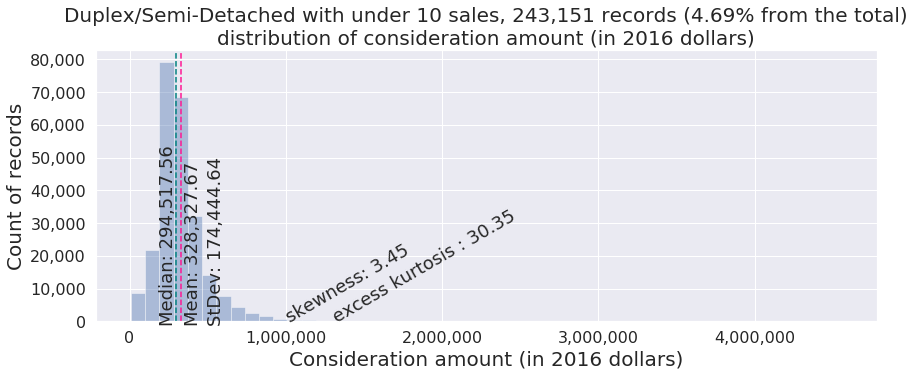

In [34]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=1.07, med_xlift=0.65, sdev_xlift=1.5)

#### Add new binary variable and new class to `lu_class`

In [35]:
df.loc[mask1 & mask2 & mask3, 'lu_class'] = lu_type
df.loc[mask1 & mask2 & mask3, 'luc_duplex'] = True
df['luc_duplex'] = df['luc_duplex'].fillna(False)
df['luc_duplex'].value_counts()

False    4945362
True      243151
Name: luc_duplex, dtype: int64

### Townhouse
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

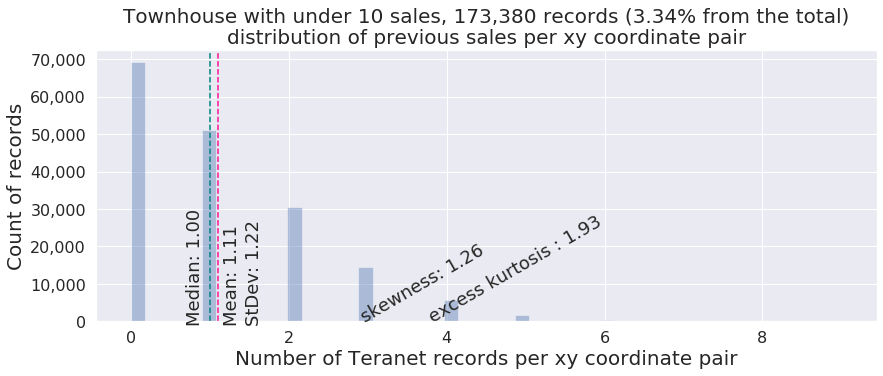

In [36]:
lu_type = 'Townhouse'
max_sales = 10
mask1 = df['code'] == lu_type
mask2 = df['xy_prev_sales'] < max_sales
mask3 = df[outlier_col] == False
s = df[mask1 & mask2 & mask3]

plot_hist(s['xy_prev_sales'], form_y=True, 
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of previous sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.05, med_xlift=0.7, sdev_xlift=1.3)

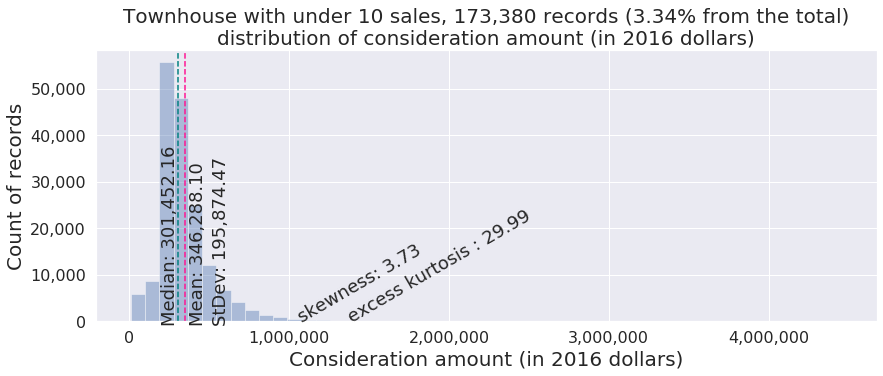

In [37]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0} with under {1} sales, {2:,} records ({3:.2f}% from the total)"
          .format(lu_type, max_sales, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=1.07, med_xlift=0.65, sdev_xlift=1.5)

#### Add new binary variable and new class to `lu_class`

In [38]:
df.loc[mask1 & mask2 & mask3, 'lu_class'] = lu_type
df.loc[mask1 & mask2 & mask3, 'luc_townhouse'] = True
df['luc_townhouse'] = df['luc_townhouse'].fillna(False)
df['luc_townhouse'].value_counts()

False    5015133
True      173380
Name: luc_townhouse, dtype: int64

### Mix(Commercial Residential)
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

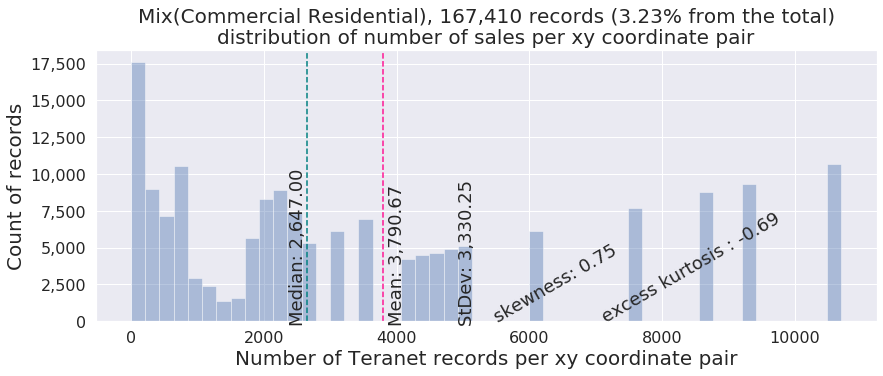

In [39]:
lu_type = 'Mix(Commercial Residential)'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3, skew_xlift=1.1)

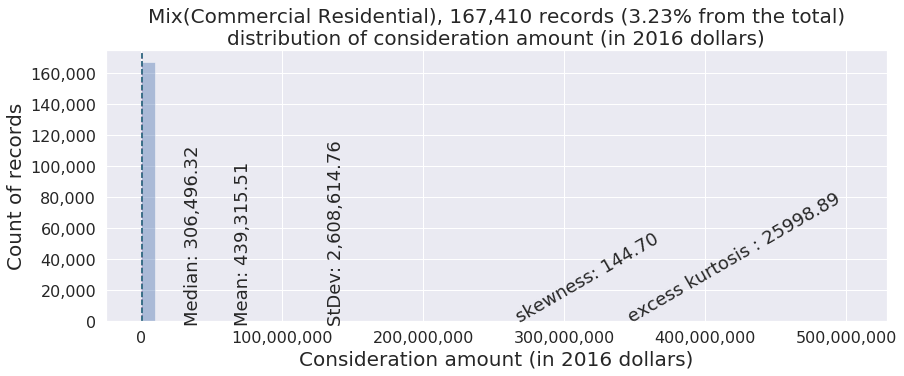

In [40]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=150, med_xlift=100, sdev_xlift=300)

#### Add new binary variable and new class to `lu_class`

In [41]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_mixuse'] = True
df['luc_mixuse'] = df['luc_mixuse'].fillna(False)
df['luc_mixuse'].value_counts()

False    5021103
True      167410
Name: luc_mixuse, dtype: int64

### Underdeveloped Land
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

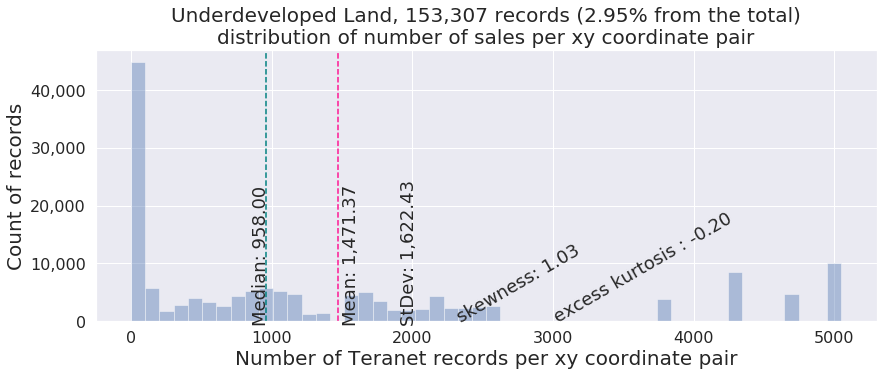

In [42]:
lu_type = 'Underdeveloped Land'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3, skew_xlift=1.2)

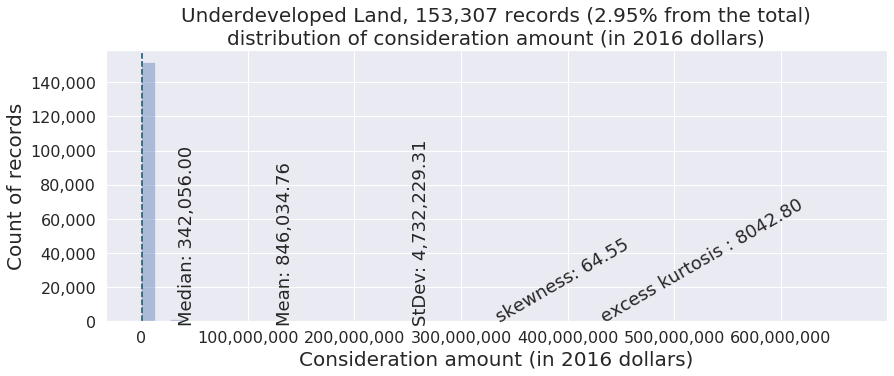

In [43]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=150, med_xlift=100, sdev_xlift=300, skew_xlift=1.3)

#### Add new binary variable and new class to `lu_class`

In [44]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_underdeveloped'] = True
df['luc_underdeveloped'] = df['luc_underdeveloped'].fillna(False)
df['luc_underdeveloped'].value_counts()

False    5035206
True      153307
Name: luc_underdeveloped, dtype: int64

### Mixed Complex (Residential, Office, Retail)
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

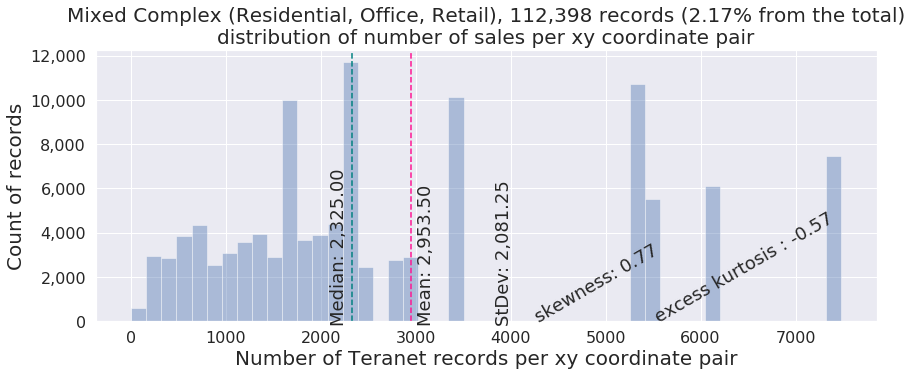

In [45]:
lu_type = 'Mixed Complex (Residential, Office, Retail)'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.02, med_xlift=0.9, sdev_xlift=1.3, skew_xlift=1.1)

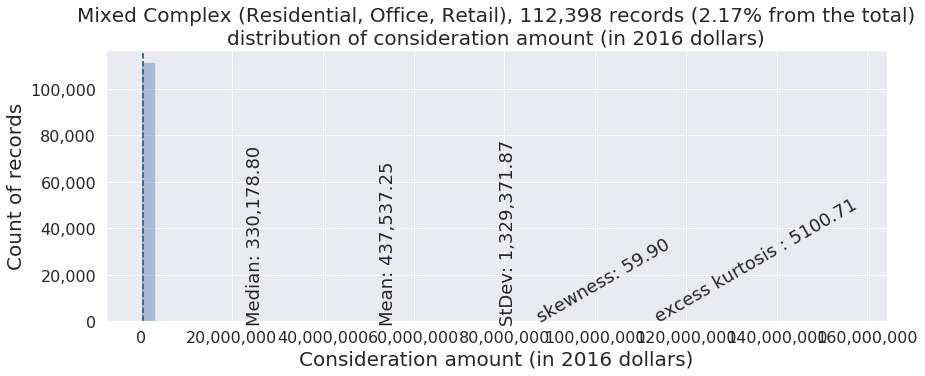

In [46]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=120, med_xlift=70, sdev_xlift=180, skew_xlift=1.1)

#### Add new binary variable and new class to `lu_class`

In [47]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_mixedcomplex'] = True
df['luc_mixedcomplex'] = df['luc_mixedcomplex'].fillna(False)
df['luc_mixedcomplex'].value_counts()

False    5076115
True      112398
Name: luc_mixedcomplex, dtype: int64

### Industrial/Employment Lands
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

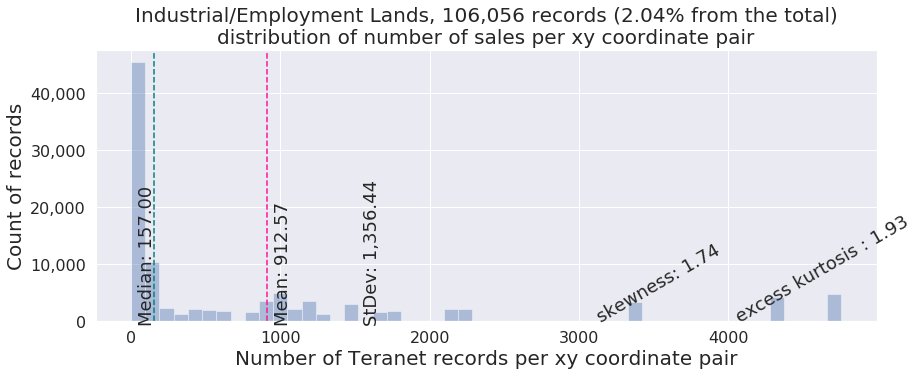

In [48]:
lu_type = 'Industrial/Employment Lands'
mask1 = df['code'] == lu_type
s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.05, med_xlift=0.3, sdev_xlift=1.7)

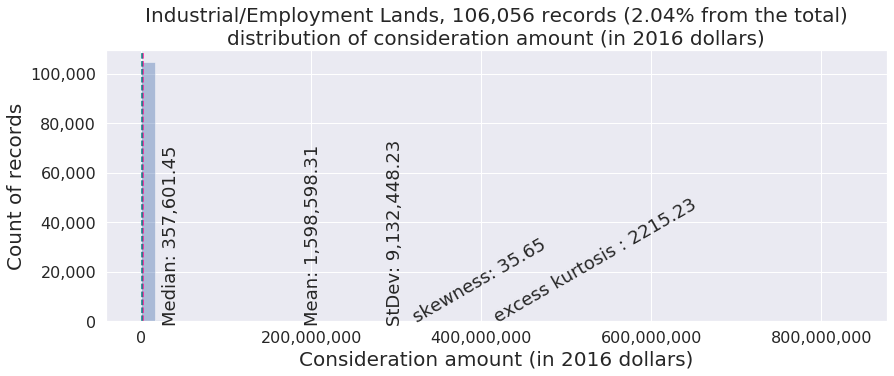

In [49]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=120, med_xlift=70, sdev_xlift=180, skew_xlift=1.1)

#### Add new binary variable and new class to `lu_class`

In [50]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_industrial'] = True
df['luc_industrial'] = df['luc_industrial'].fillna(False)
df['luc_industrial'].value_counts()

False    5082457
True      106056
Name: luc_industrial, dtype: int64

### Commercial/Shopping
#### Set selection criteria and display distributions of price and count of records per xy coordinate pair

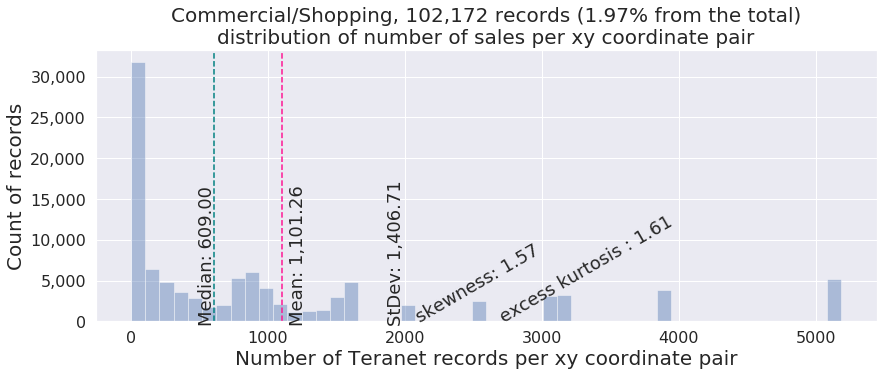

In [51]:
lu_type = 'Commercial/Shopping'
mask1 = df['code'] == lu_type

s = df[mask1]

plot_hist(s['xy_total_sales'], form_y=True, 
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of number of sales per xy coordinate pair",
          x_label="Number of Teranet records per xy coordinate pair", 
          mean_xlift=1.05, med_xlift=0.8, sdev_xlift=1.7, skew_xlift=1.1)

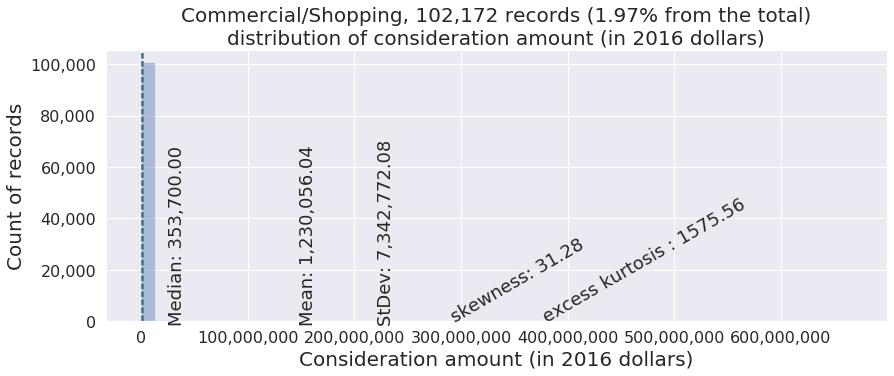

In [52]:
plot_hist(s['price_2016'].dropna(), form_y=True, form_x=True,
          title="{0}, {1:,} records ({2:.2f}% from the total)"
          .format(lu_type, len(s), len(s) / len(df) * 100) + \
          "\ndistribution of consideration amount (in 2016 dollars)",
          x_label="Consideration amount (in 2016 dollars)", 
          mean_xlift=120, med_xlift=70, sdev_xlift=180, skew_xlift=1.3)

#### Add new binary variable and new class to `lu_class`

In [53]:
df.loc[mask1, 'lu_class'] = lu_type
df.loc[mask1, 'luc_commercial'] = True
df['luc_commercial'] = df['luc_commercial'].fillna(False)
df['luc_commercial'].value_counts()

False    5086341
True      102172
Name: luc_commercial, dtype: int64

#### Validate number of records

In [54]:
df['luc_detached'].sum() + df['luc_condo'].sum() + df['luc_strata'].sum() + \
    df['luc_duplex'].sum() + df['luc_townhouse'].sum() + df['luc_mixuse'].sum() + \
    df['luc_mixedcomplex'].sum() + df['luc_industrial'].sum() + df['luc_commercial'].sum()

4371829

In [55]:
df['lu_class'].value_counts().sum()

4525136

In [56]:
df['lu_class'].value_counts()

Single Detached House                          2061867
Apartments/Condos/Residence                    1092568
Strata Townhouses                               312827
Duplex/Semi-Detached                            243151
Townhouse                                       173380
Mix(Commercial Residential)                     167410
Underdeveloped Land                             153307
Mixed Complex (Residential, Office, Retail)     112398
Industrial/Employment Lands                     106056
Commercial/Shopping                             102172
Name: lu_class, dtype: int64

## Encode land use into 3 classes: house, condo and other
Land use classes produced above will be reduced to a 3 class case:
1. Houses (single detached, duplex/semi-detached, townhouses)
2. Condos (apartments/condos, strata townhouses)
3. Everything else (mix use, commercial, industrial, etc.)

New classes will be encoded one-hot and as a single categorical variable.
### Distributions of price

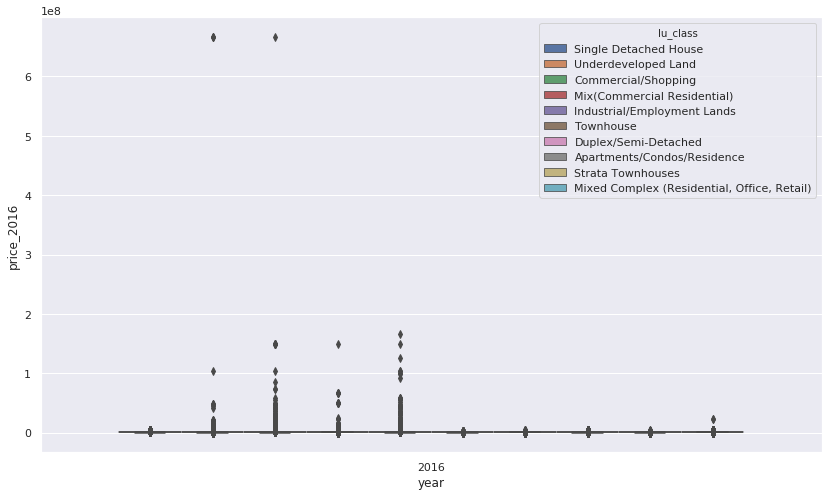

In [57]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='price_2016', hue='lu_class', ax=ax)
plt.show()

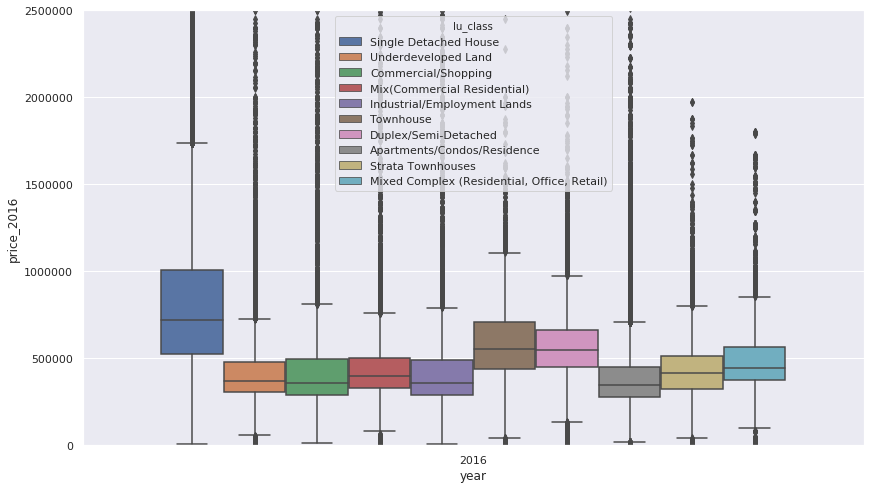

In [58]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='price_2016', hue='lu_class', ax=ax)
ax.set_ylim(0, 2500000)
plt.show()

### Distribtutions of total sales per xy coordinate pair

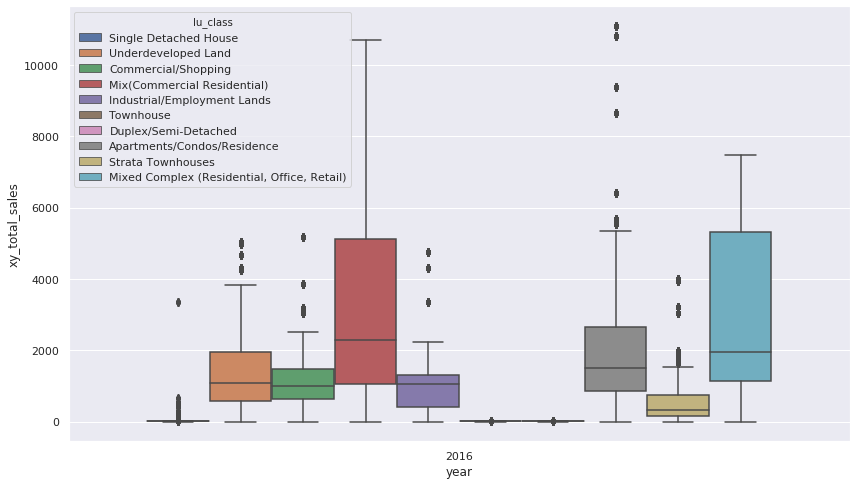

In [59]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='xy_total_sales', hue='lu_class', ax=ax)
plt.show()

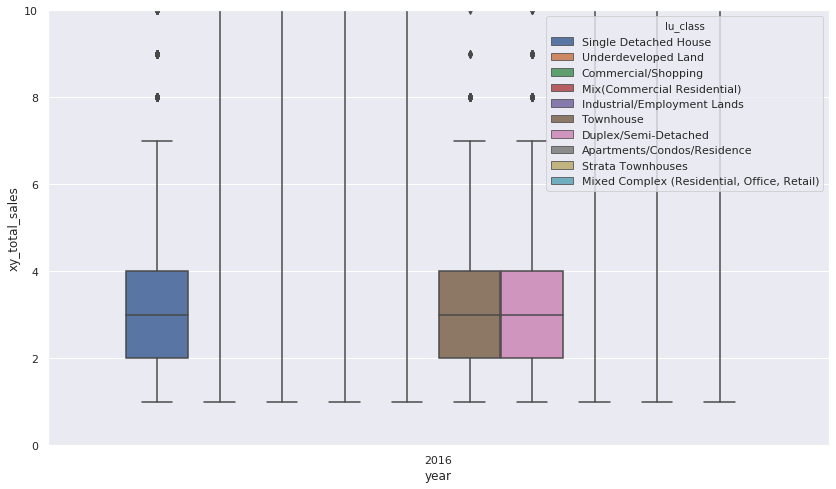

In [60]:
year = 2016
f, ax = plt.subplots(1, figsize=(14, 8))
sns.boxplot(data=df.query('year == @year'), x='year', y='xy_total_sales', hue='lu_class', ax=ax)
ax.set_ylim(0, 10)
plt.show()

### Encode variables into 3 categories
Options tried before:

**Three classes**: "house", "condo", "other"

* house: detached + duplex + townhouse
* condo: condos + strata
* other: everything else

**Four classes**: "detached", "duplex_townhouse", "condo", "other"

* detached: detached
* duplex_townhouse: duplex + townhouse
* condo: condos + strata
* other: everything else

#### Class "detached": Single detached houses

In [61]:
cat_list = ['Single Detached House']
mask1 = df['lu_class'].isin(cat_list)
df.loc[mask1, 'lucr_detached'] = True
df.loc[mask1, 'lucr'] = 'detached'
df['lucr_detached'] = df['lucr_detached'].fillna(False)
df['lucr_detached'].value_counts()

False    3126646
True     2061867
Name: lucr_detached, dtype: int64

#### Class "duplex_townhouse": Duplex/Semi-Detached and Townhouses

In [62]:
cat_list = ['Duplex/Semi-Detached', 'Townhouse']
mask1 = df['lu_class'].isin(cat_list)
df.loc[mask1, 'lucr_duplex_townhouse'] = True
df.loc[mask1, 'lucr'] = 'duplex_townhouse'
df['lucr_duplex_townhouse'] = df['lucr_duplex_townhouse'].fillna(False)
df['lucr_duplex_townhouse'].value_counts()

False    4771982
True      416531
Name: lucr_duplex_townhouse, dtype: int64

#### Category "condo": apartments/condos and strata townhouses

In [63]:
cat_list = ['Apartments/Condos/Residence', 'Strata Townhouses']
mask1 = df['lu_class'].isin(cat_list)
df.loc[mask1, 'lucr_condo'] = True
df.loc[mask1, 'lucr'] = 'condo'
df['lucr_condo'] = df['lucr_condo'].fillna(False)
df['lucr_condo'].value_counts()

False    3783118
True     1405395
Name: lucr_condo, dtype: int64

#### Category "other": mixed, commercial, industrial and all other development types

In [64]:
mask1 = df['lucr_detached'] == False
mask2 = df['lucr_duplex_townhouse'] == False
mask3 = df['lucr_condo'] == False
df.loc[mask1 & mask2 & mask3, 'lucr_other'] = True
df.loc[mask1 & mask2 & mask3, 'lucr'] = 'other'
df['lucr_other'] = df['lucr_other'].fillna(False)
df['lucr_other'].value_counts()

False    3883793
True     1304720
Name: lucr_other, dtype: int64

#### Count of Teranet records by reduced land use category

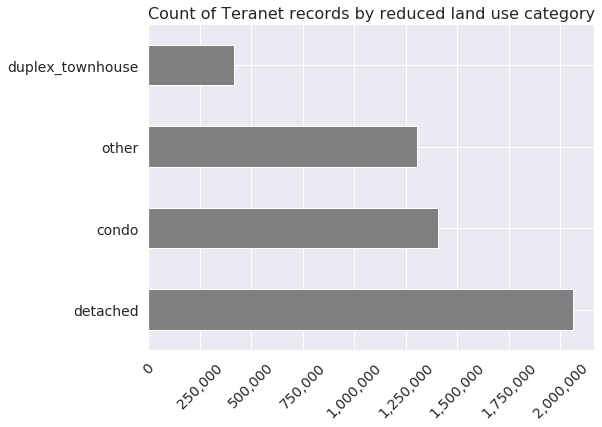

In [65]:
f, ax = plt.subplots(1, figsize=(8, 6))
df['lucr'].value_counts().plot(kind='barh', ax=ax, color='gray')
ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Count of Teranet records by reduced land use category", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

## Train a classification algorithm and add a new column `lucr_predict`
Census variables, along with the new Teranet features, are used by a machine learning algorithm to classify land use from Teranet and Census data; then Census variables are removed from the final Teranet dataset, and the new column `lucr_predict` is added to each Teranet records. 

This new attribute represents reduced land use class ("house", "condo", or "other"), as predicted by a machine learning algorithm trained on the housing market dynamics, as seen by Census data and new Teranet features.

### Temporarily join all select Census variables
All select Census variables are temporarily joined to Teranet records (by `dauid` and `census2001_year`).

#### Load Census data

In [ ]:
census_path = data_path + '../da_census/'
os.listdir(census_path)

In [ ]:
t = time()

census_df = pd.read_csv(census_path + 'da_census_select_tidy.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(census_df.shape[0], census_df.shape[1]) + 
      "\n-- Column names:\n", census_df.columns)

#### Join Census data to Teranet data

In [ ]:
df = pd.merge(df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})

print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

### Take a train-test and two validation subsets from Teranet records
Subset of Teranet records from 2011 is used to train and test a machine learning algorithm classifying the three reduced categories of land use ("house", "condo" or "other"), as derived in this notebook from the detailed land use provided by the Department of Geography.

Subsets of Teranet records from 2010 and 2012 are used to validate algorithm's predictions.

In [ ]:
year_train_test = 2011
year_val1 = 2010
year_val2 = 2012

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

### Subset columns with features and target, drop missing values

In [ ]:
all_feat_cols = ['pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
                 'xy_first_sale', 'pin_years_since_last_sale',
                 'xy_years_since_last_sale', 'xy_years_to_next_sale',
                 'da_days_since_last_sale', 'da_years_since_last_sale',
                 'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
                 'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
                 'price_da_pct_change', 'med_price_xy', 'med_price_year',
                 'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
                 'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
                 'outlier_xy_10', 
                 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
                 'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
                 'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
                 'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
                 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
                 'Usl_wkpl', 'Blue_cljob', 'White_cljob',
                 'lucr_detached', 'lucr_duplex_townhouse', 'lucr', 'lucr_condo', 'lucr_other']
s = s[all_feat_cols]
s_val1 = s_val1[all_feat_cols]
s_val2 = s_val2[all_feat_cols]
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

### Encode target

In [ ]:
le = LabelEncoder()
s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop('lucr', axis=1)
s_val1 = s_val1.drop('lucr', axis=1)
s_val2 = s_val2.drop('lucr', axis=1)
print("Land use encoded!")
labels = {0: 'condo', 1: 'detached', 2: 'duplex_townhouse', 3: 'other'}

### Select features and target

In [ ]:
non_feat_cols = 5
s.columns[1:-non_feat_cols]

In [ ]:
feat_cols = s.columns[1:-non_feat_cols]
target_col = 'lucr_e'

X = s[feat_cols].values
y = s[target_col].values
X_val1 = s_val1[feat_cols].values
y_val1 = s_val1[target_col].values
X_val2 = s_val2[feat_cols].values
y_val2 = s_val2[target_col].values

print("Features and target selected.")

### Perform the train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

### Train and test classification algorithms

In [ ]:
model_name = 'Logistic regression (raw features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

In [ ]:
model_name = 'Random Forest'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

### Add new column `lucr_predict` to Teranet records

In [ ]:
t = time()

forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
forest.fit(X, y)

mask1 = df[feat_cols].notnull().all(axis=1)
df.loc[mask1, 'lucr_predict'] = forest.predict(df.loc[mask1, feat_cols].values)

elapsed = time() - t
print("New column 'lucr_predict' was added to the DataFrame. Took {0:,.2f} seconds ({1:,.2f} minutes)."
      .format(elapsed, elapsed / 60))

In [ ]:
df['lucr_predict'] = df['lucr_predict'].map(labels)

## Save results to a new .csv file
Teranet dataset without NaN records and with new columns is saved as:
`data/HHSaleHistory_cleaned_v0.9_GTHA_DA_with_cols_v0.9.csv`

In [ ]:
df = df.drop(census_df.columns[2:], axis=1)
df.columns

In [ ]:
save_path = data_path + '4_Teranet_lu_predict.csv'
t = time()
df.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds ({1:.2f} minutes).".format(elapsed, elapsed / 60))